# 1. MNIST 데이터셋을 97% 이상의 정확도로 구분해내기 (kNeighborsClassifier 사용 추천)

### 데이터셋 다운 및 준비

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

((70000, 784), (70000,))

### 그리드 파라메터 제작 및 학습

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


grid_params = {
    'n_neighbors':np.arange(1, 11, 1),
    'weights':['uniform', 'distance'],
    # 'metric':['minkowski', 'euclidean', 'mahalannobis'],
}

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, grid_params, cv=5, verbose=3, scoring ="accuracy")
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.970 total time=  15.1s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.971 total time=  14.0s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.969 total time=  14.0s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.969 total time=  14.2s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.968 total time=  14.0s
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.970 total time=  13.8s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.971 total time=  13.6s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.969 total time=  13.8s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.969 total time=  13.7s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.968 total time=  13.8s
[CV 1/5] END ....n_neighbors=2, weights=uniform;, score=0.964 total time=  14.6s
[CV 2/5] END ....n_neighbors=2, weights=uniform

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

In [8]:
grid_search.best_score_, grid_search.best_params_

(0.9716166666666666, {'n_neighbors': 4, 'weights': 'distance'})

In [9]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

# 2. MNIST 이미지 데이테셋을 상하좌우로 1픽셀씩 이동하여 데이터 증폭시키고 위에서 찾은 모델로 훈련해보기

In [111]:
from datetime import datetime

def make_move_pixel_dataset(X, moving):
    X_result = X.copy().reshape(len(X), 28, 28)
    x_move = [moving, 0, -moving, 0]
    y_move = [0, moving, 0, -moving]
    
    for move_idx in range(len(x_move)):
        X_reshape = X.copy().reshape(len(X), 28, 28)
        # print(X_reshape.shape)
        for i, _X in enumerate(X_reshape):
            # print(_X.shape, len(_X), len(_X[0]))
            for _X_y in range(len(_X)):
                for _X_x in range(len(_X[0])):
                    y_pos = _X_y+y_move[move_idx]
                    x_pos = _X_x+x_move[move_idx]
                    # print(_X_y, _X_x,'->', y_pos, x_pos)
                    # print((y_pos < 0) , (x_pos < 0) , (y_pos >= len(_X)) , (x_pos >= len(_X[0])))
                    if (y_pos < 0) | (x_pos < 0) | (y_pos >= len(_X)) | (x_pos >= len(_X[0])):
                        continue
                    else:
                        X_reshape[i][y_pos][x_pos] = X_result[i][_X_y][_X_x]
            
            if x_move[move_idx] > 0:
                X_reshape[i,:,:x_move[move_idx]]=0
            if y_move[move_idx] > 0:
                X_reshape[i,:y_move[move_idx]]=0
            if x_move[move_idx] < 0:
                X_reshape[i,:,x_move[move_idx]:]=0
            if y_move[move_idx] < 0:
                X_reshape[i,y_move[move_idx]:]=0
        
        X_result = np.concatenate([X_result, X_reshape], axis=0)
        print(datetime.now(), X_result.shape)
        # if move_idx == 1:
        #     break
    
    return X_result

In [ ]:
print('start\t\t', datetime.now())
test_X = make_move_pixel_dataset(X_train.values, 5)
print('end\t\t',datetime.now())

start		 2022-01-16 19:15:16.986884
2022-01-16 19:16:00.885626 (120000, 28, 28)
2022-01-16 19:16:45.951925 (180000, 28, 28)
2022-01-16 19:17:30.750798 (240000, 28, 28)
2022-01-16 19:18:18.892067 (300000, 28, 28)
end		 2022-01-16 19:18:19.115056


In [112]:
test_X.shape

(300000, 28, 28)

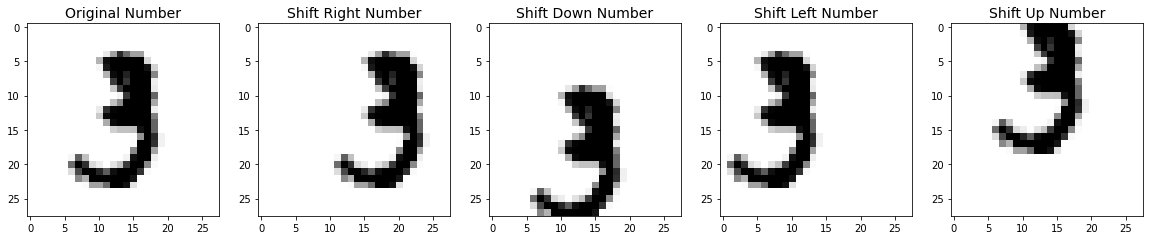

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(151)
plt.title('Original Number', fontsize=14)
plt.imshow(test_X[10], interpolation='nearest', cmap='Greys')
plt.subplot(152)
plt.title('Shift Right Number', fontsize=14)
plt.imshow(test_X[10+len(X_train)], interpolation='nearest', cmap='Greys')
plt.subplot(153)
plt.title('Shift Down Number', fontsize=14)
plt.imshow(test_X[10+(len(X_train)*2)], interpolation='nearest', cmap='Greys')
plt.subplot(154)
plt.title('Shift Left Number', fontsize=14)
plt.imshow(test_X[10+(len(X_train)*3)], interpolation='nearest', cmap='Greys')
plt.subplot(155)
plt.title('Shift Up Number', fontsize=14)
plt.imshow(test_X[10+(len(X_train)*4)], interpolation='nearest', cmap='Greys')
plt.show()

In [119]:
X_train_enlarge = test_X.reshape(len(test_X), 28*28)
y_train_enlarge = np.concatenate([y_train,y_train,y_train,y_train,y_train], axis=0)
print(X_train_enlarge.shape, y_train_enlarge.shape)
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_enlarge, y_train_enlarge)

(300000, 784) (300000,)


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [121]:
y_pred_enlarge = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred_enlarge)

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.9708

In [115]:
# 본문에서 제시한 방법 (속도가 엄청 빠름...)
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

print('start\t\t', datetime.now())
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train.values, y_train.values):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)
print('end\t\t', datetime.now())

start		 2022-01-16 19:20:04.014626
end		 2022-01-16 19:20:37.426633


D:\anaconda3\envs\ml_study\lib\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


# 3. 타이타닉 생존자 예측하기

### 데이터셋 다운 및 준비

In [443]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()

In [590]:
import pandas as pd

def load_titanic_data(filename, titanic_path):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

train_data = load_titanic_data('train.csv', TITANIC_PATH)
test_data = load_titanic_data('test.csv', TITANIC_PATH)
print(train_data.groupby(['Survived']).size())

Survived
0    549
1    342
dtype: int64


In [591]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


속성 설명:
* **PassengerId**: 각 승객의 고유 식별자.
* **Survived**: 타깃입니다. 0은 생존하지 못한 것이고 1은 생존을 의미합니다.
* **Pclass**: 승객 등급. 1, 2, 3등석.
* **Name**, **Sex**, **Age**: 이름 그대로 의미입니다.
* **SibSp**: 함께 탑승한 형제, 배우자의 수.
* **Parch**: 함께 탑승한 자녀, 부모의 수.
* **Ticket**: 티켓 아이디
* **Fare**: 티켓 요금 (파운드)
* **Cabin**: 객실 번호
* **Embarked**: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)

In [592]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


데이터 카운팅 결과
* Cabin의 경우 없는 데이터가 너무 많고 쉽사리 채우기 힘든 특성이어서 제거
* Age의 경우 생존에 연관성이 큰 특성으로 보이기 때문에 median 값으로 채움
* Embarked 는 nan 인 행만 제거

In [593]:
train_data.drop('Cabin', axis=1, inplace=True)

In [594]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


In [595]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [596]:
train_data['Age']=train_data['Age'].fillna(train_data.describe()['Age']['50%'])

In [597]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [598]:
train_data[train_data['Embarked'].isnull()].index.tolist()

[61, 829]

In [599]:
train_data.drop(train_data[train_data['Embarked'].isnull()].index.tolist(), axis=0, inplace=True)

In [600]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [601]:
# 나이데이터에 소수점이 들어가있음 이를 제거하기 위해서 올림할지 반올림할지 정하려고 함
float_indexes = np.where(train_data['Age'].values<1)
for i in float_indexes:
    print(i,train_data['Age'].values[i])

[ 77 304 468 643 754 802 829] [0.83 0.92 0.75 0.75 0.67 0.42 0.83]


0.42 와 같은 데이터는 0살로 치부되기때문에 올림을 하기로함.

In [602]:
import math
train_data['Age']=[math.ceil(x) for x in train_data['Age']]

In [603]:
# 확인
for i in float_indexes:
    print(i,train_data['Age'].values[i])

[ 77 304 468 643 754 802 829] [1 1 1 1 1 1 1]


데이터 분석 시작
* 우선 상관관계를 알아보기 위해서 관계가 있을법한 데이터와 예측결과의 정답인 Survived 데이터와 비교하여 그래프를 그려봄
* Pclass : 티켓의 등급이 높다면 생존확률이 높을것으로 예측됨
* Sex : 성별이 여성일 경우 우선적으로 구해졌기 때문에 생족확률이 높을것으로 예측됨
* Age : 어린나이일수록 우선적으로 구해졌기 때문에 생존확률이 높을것으로 예측됨

우선 이정도

In [604]:
print(train_data.groupby(['Pclass', 'Survived']).size())
print(train_data.groupby(['Sex', 'Survived']).size())
print(train_data.groupby(['Age', 'Survived']).size())

Pclass  Survived
1       0            80
        1           134
2       0            97
        1            87
3       0           372
        1           119
dtype: int64
Sex     Survived
female  0            81
        1           231
male    0           468
        1           109
dtype: int64
Age  Survived
1    0            2
     1           12
2    0            7
     1            3
3    0            1
                 ..
66   0            1
70   0            2
71   0            3
74   0            1
80   1            1
Length: 123, dtype: int64


In [605]:
pclass_count = train_data.groupby(['Pclass', 'Survived']).size()
sex_count = train_data.groupby(['Sex', 'Survived']).size()
age_count = train_data.groupby(['Age', 'Survived']).size()

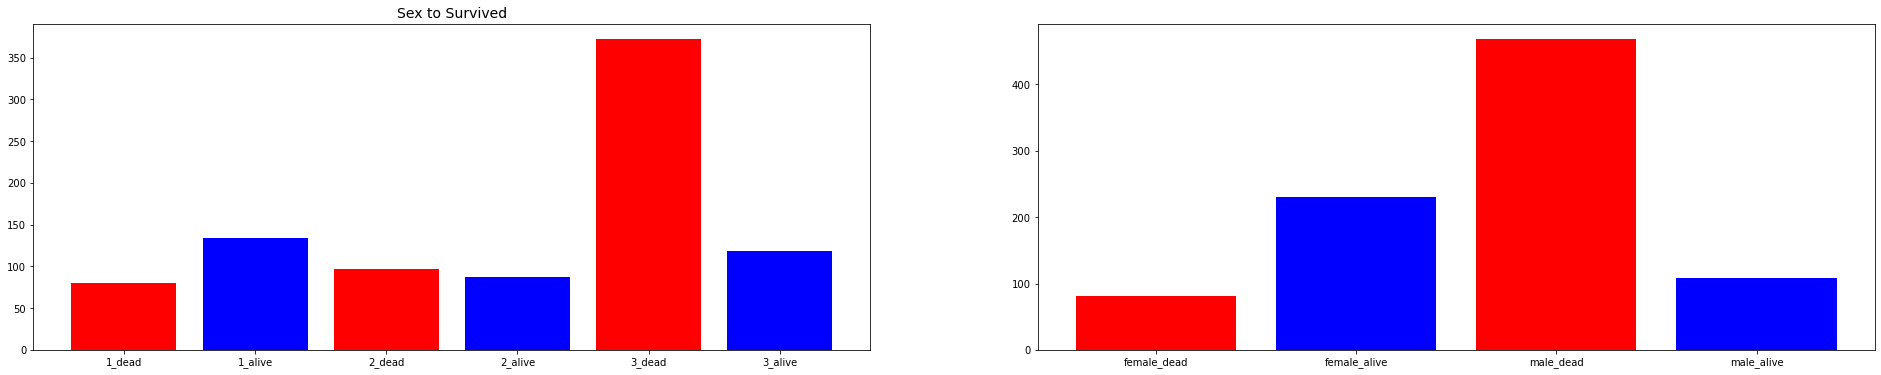

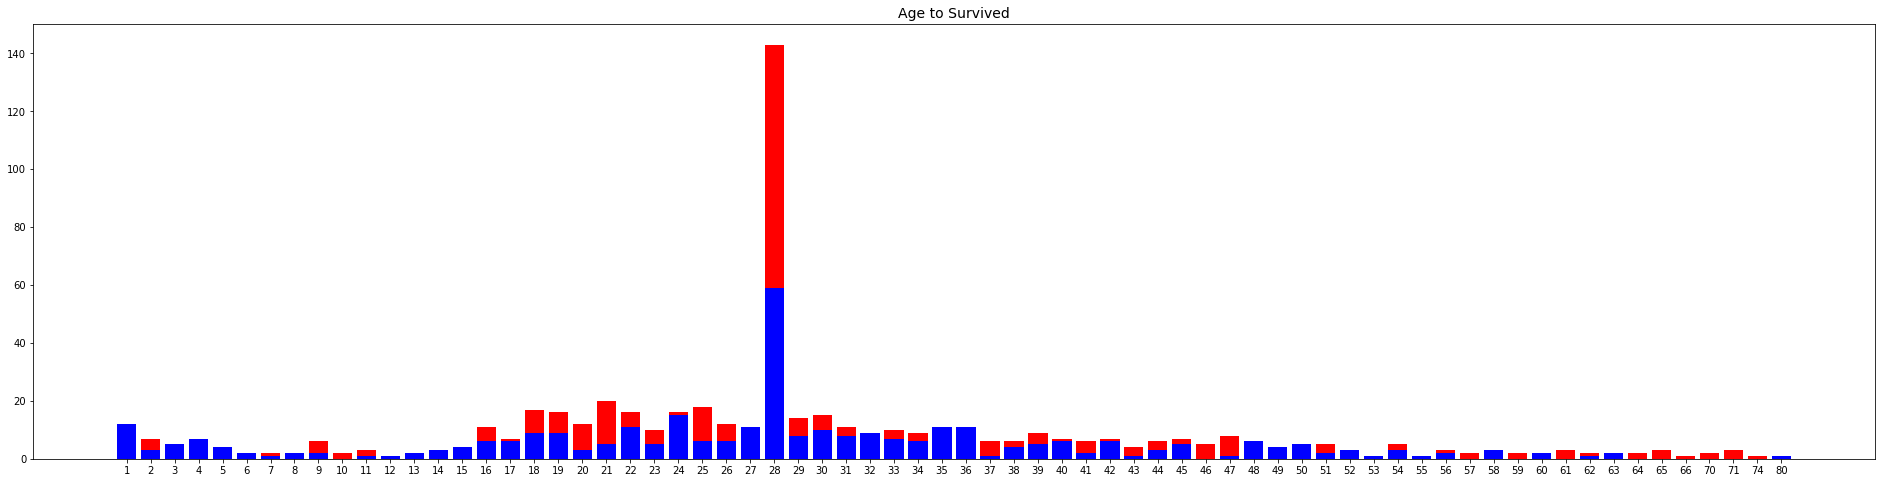

In [606]:
plt.figure(figsize=(33,6))

plt.title('Pclass to Survived', fontsize=14)
plt.subplot(121)
plt.bar('1_dead', pclass_count[1][0], color='r')
plt.bar('1_alive', pclass_count[1][1], color='b')
plt.bar('2_dead', pclass_count[2][0], color='r')
plt.bar('2_alive', pclass_count[2][1], color='b')
plt.bar('3_dead', pclass_count[3][0], color='r')
plt.bar('3_alive', pclass_count[3][1], color='b')

plt.title('Sex to Survived', fontsize=14)
plt.subplot(122)
plt.bar('female_dead', sex_count['female'][0], color='r')
plt.bar('female_alive', sex_count['female'][1], color='b')
plt.bar('male_dead', sex_count['male'][0], color='r')
plt.bar('male_alive', sex_count['male'][1], color='b')
plt.show()

plt.figure(figsize=(33,8))
plt.title('Age to Survived', fontsize=14)
for _age, _state in age_count.index:
    if _state==0:
        plt.bar(f'{_age}', age_count[_age][_state], color='r')
    else:
        plt.bar(f'{_age}', age_count[_age][_state], color='b')
plt.show()

3개의 특성 시각화 결과
* 3 등급의 티켓 사람들이 많이 죽음
* 남자일수록 죽고 여자일수록 생존
* 28의 데이터가 너무많은데 이는 아까 결측치를 median 값인 28 로 다채웠기때문
* 큰 차이는 없어보이지만 18 ~ 30살, 37 ~ 47살, 61살 ~ 의 경우 죽는 경우가 더 큼

In [612]:
# 상관분석을 위한 one_hot_encoding 시작
# Sex 특징을 onehot으로 변환
sex_dummy = pd.get_dummies(train_data['Sex'])
train_data_dummy = pd.merge(left=train_data.drop('Sex', axis=1), right=sex_dummy, left_index=True, right_index=True)

pclass_dummy = pd.get_dummies(train_data_dummy['Pclass'])
train_data_dummy = pd.merge(left=train_data_dummy.drop('Pclass', axis=1), right=pclass_dummy, left_index=True, right_index=True)

# age_dummy = pd.get_dummies(train_data_dummy['Age'])
# train_data_dummy = pd.merge(left=train_data_dummy.drop('Age', axis=1), right=age_dummy, left_index=True, right_index=True)

train_data_dummy

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,female,male,1,2,3
0,1,0,"Braund, Mr. Owen Harris",22,1,0,A/5 21171,7.2500,S,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38,1,0,PC 17599,71.2833,C,1,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26,0,0,STON/O2. 3101282,7.9250,S,1,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,1,0,113803,53.1000,S,1,0,1,0,0
4,5,0,"Allen, Mr. William Henry",35,0,0,373450,8.0500,S,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",27,0,0,211536,13.0000,S,0,1,0,1,0
887,888,1,"Graham, Miss. Margaret Edith",19,0,0,112053,30.0000,S,1,0,1,0,0
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",28,1,2,W./C. 6607,23.4500,S,1,0,0,0,1
889,890,1,"Behr, Mr. Karl Howell",26,0,0,111369,30.0000,C,0,1,1,0,0


In [613]:
train_data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Name         889 non-null    object 
 3   Age          889 non-null    int64  
 4   SibSp        889 non-null    int64  
 5   Parch        889 non-null    int64  
 6   Ticket       889 non-null    object 
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
 9   female       889 non-null    uint8  
 10  male         889 non-null    uint8  
 11  1            889 non-null    uint8  
 12  2            889 non-null    uint8  
 13  3            889 non-null    uint8  
dtypes: float64(1), int64(5), object(3), uint8(5)
memory usage: 106.1+ KB


In [614]:
corr_matrix = train_data_dummy.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
female         0.541585
1              0.282368
Fare           0.255290
2              0.095002
Parch          0.083151
PassengerId   -0.005028
SibSp         -0.034040
Age           -0.070143
3             -0.320171
male          -0.541585
Name: Survived, dtype: float64

corr 상관분석 결과
* Sex가 제일 높음
* Pclass가 높음
* Fare도 높음 -> 티켓가격이니 Pclass와 비슷한 관계
* Age는 그렇게 높진 않지만 낮은 특징들에 비해서는 높은 수준
* 상관분석도가 낮은 PassengerId, SibSp, Parch 는 제거하고 학습하는게 도움이 클듯
* 또한, 학습에 어려운 데이터인 Name, Ticket, Embarked 데이터는 제거하고 학습

In [615]:
train_data_last = train_data_dummy.drop(['PassengerId', 'SibSp', 'Parch', 'Name', 'Ticket', 'Embarked'],axis=1)
train_data_last.head()
X_train = train_data_last.drop('Survived', axis=1)
y_train = train_data_last[['Survived']]
X_train.shape, y_train.shape

((889, 7), (889, 1))

In [616]:
X_train.head()

,Age,Fare,female,male,1,2,3
0,22,7.2500,0,1,0,0,1
1,38,71.2833,1,0,1,0,0
2,26,7.9250,1,0,0,0,1
3,35,53.1000,1,0,1,0,0
4,35,8.0500,0,1,0,0,1


In [617]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

grid_params ={
    'n_estimators':[5, 10, 20, 30, 40, 50, 100, 150, 200, 250, 300],
    'max_features':[3,4,5,6,7,8,9,10]
}

rndf_clf=RandomForestClassifier()
grid_search = GridSearchCV(rndf_clf, grid_params, cv=5, verbose=3)
grid_search.fit(X_train.values, y_train.values)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
[CV 1/5] END ....max_features=3, n_estimators=5;, score=0.758 total time=   0.0s
[CV 2/5] END ....max_features=3, n_estimators=5;, score=0.770 total time=   0.0s
[CV 3/5] END ....max_features=3, n_estimators=5;, score=0.843 total time=   0.0s
[CV 4/5] END ....max_features=3, n_estimators=5;, score=0.792 total time=   0.0s
[CV 5/5] END ....max_features=3, n_estimators=5;, score=0.836 total time=   0.0s
[CV 1/5] END ...max_features=3, n_estimators=10;, score=0.758 total time=   0.0s
[CV 2/5] END ...max_features=3, n_estimators=10;, score=0.820 total time=   0.0s
[CV 3/5] END ...max_features=3, n_estimators=10;, score=0.871 total time=   0.0s
[CV 4/5] END ...max_features=3, n_estimators=10;, score=0.792 total time=   0.0s
[CV 5/5] END ...max_features=3, n_estimators=10;, score=0.831 total time=   0.0s
[CV 1/5] END ...max_features=3, n_estimators=20;, score=0.753 total time=   0.0s

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec


[CV 2/5] END ...max_features=3, n_estimators=20;, score=0.798 total time=   0.0s
[CV 3/5] END ...max_features=3, n_estimators=20;, score=0.843 total time=   0.0s
[CV 4/5] END ...max_features=3, n_estimators=20;, score=0.798 total time=   0.0s
[CV 5/5] END ...max_features=3, n_estimators=20;, score=0.825 total time=   0.0s
[CV 1/5] END ...max_features=3, n_estimators=30;, score=0.781 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ...max_features=3, n_estimators=30;, score=0.815 total time=   0.0s
[CV 3/5] END ...max_features=3, n_estimators=30;, score=0.826 total time=   0.0s
[CV 4/5] END ...max_features=3, n_estimators=30;, score=0.798 total time=   0.0s
[CV 5/5] END ...max_features=3, n_estimators=30;, score=0.814 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 1/5] END ...max_features=3, n_estimators=40;, score=0.770 total time=   0.0s
[CV 2/5] END ...max_features=3, n_estimators=40;, score=0.803 total time=   0.0s
[CV 3/5] END ...max_features=3, n_estimators=40;, score=0.848 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ...max_features=3, n_estimators=40;, score=0.803 total time=   0.0s
[CV 5/5] END ...max_features=3, n_estimators=40;, score=0.836 total time=   0.0s
[CV 1/5] END ...max_features=3, n_estimators=50;, score=0.787 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ...max_features=3, n_estimators=50;, score=0.798 total time=   0.0s
[CV 3/5] END ...max_features=3, n_estimators=50;, score=0.843 total time=   0.0s
[CV 4/5] END ...max_features=3, n_estimators=50;, score=0.815 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ...max_features=3, n_estimators=50;, score=0.831 total time=   0.0s
[CV 1/5] END ..max_features=3, n_estimators=100;, score=0.764 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=3, n_estimators=100;, score=0.815 total time=   0.1s
[CV 3/5] END ..max_features=3, n_estimators=100;, score=0.837 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=3, n_estimators=100;, score=0.798 total time=   0.1s
[CV 5/5] END ..max_features=3, n_estimators=100;, score=0.825 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=3, n_estimators=150;, score=0.781 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=3, n_estimators=150;, score=0.809 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=3, n_estimators=150;, score=0.848 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=3, n_estimators=150;, score=0.798 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=3, n_estimators=150;, score=0.825 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=3, n_estimators=200;, score=0.792 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=3, n_estimators=200;, score=0.809 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=3, n_estimators=200;, score=0.843 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=3, n_estimators=200;, score=0.798 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=3, n_estimators=200;, score=0.842 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=3, n_estimators=250;, score=0.787 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=3, n_estimators=250;, score=0.803 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=3, n_estimators=250;, score=0.854 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=3, n_estimators=250;, score=0.792 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=3, n_estimators=250;, score=0.836 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=3, n_estimators=300;, score=0.781 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=3, n_estimators=300;, score=0.803 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=3, n_estimators=300;, score=0.843 total time=   0.5s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=3, n_estimators=300;, score=0.809 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=3, n_estimators=300;, score=0.847 total time=   0.4s
[CV 1/5] END ....max_features=4, n_estimators=5;, score=0.753 total time=   0.0s
[CV 2/5] END ....max_features=4, n_estimators=5;, score=0.798 total time=   0.0s
[CV 3/5] END ....max_features=4, n_estimators=5;, score=0.798 total time=   0.0s
[CV 4/5] END ....max_features=4, n_estimators=5;, score=0.803 total time=   0.0s
[CV 5/5] END ....max_features=4, n_estimators=5;, score=0.847 total time=   0.0s
[CV 1/5] END ...max_features=4, n_estimators=10;, score=0.775 total time=   0.0s
[CV 2/5] END ...max_features=4, n_estimators=10;, score=0.792 total time=   0.0s
[CV 3/5] END ...max_features=4, n_estimators=10;, score=0.860 total time=   0.0s
[CV 4/5] END ...max_features=4, n_estimators=10;, score=0.798 total time=   0.0s
[CV 5/5] END ...max_features=4, n_estimators=10;, score=0.814 total time=   0.0s
[CV 1/5] END ...max_features=4, n_estimators=20;, score=0.775 total time=   0.0s
[CV 2/5] END ...max_features

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ...max_features=4, n_estimators=20;, score=0.854 total time=   0.0s
[CV 4/5] END ...max_features=4, n_estimators=20;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=4, n_estimators=20;, score=0.842 total time=   0.0s
[CV 1/5] END ...max_features=4, n_estimators=30;, score=0.781 total time=   0.0s
[CV 2/5] END ...max_features=4, n_estimators=30;, score=0.792 total time=   0.0s
[CV 3/5] END ...max_features=4, n_estimators=30;, score=0.848 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 4/5] END ...max_features=4, n_estimators=30;, score=0.798 total time=   0.0s
[CV 5/5] END ...max_features=4, n_estimators=30;, score=0.819 total time=   0.0s
[CV 1/5] END ...max_features=4, n_estimators=40;, score=0.792 total time=   0.0s
[CV 2/5] END ...max_features=4, n_estimators=40;, score=0.798 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ...max_features=4, n_estimators=40;, score=0.848 total time=   0.0s
[CV 4/5] END ...max_features=4, n_estimators=40;, score=0.798 total time=   0.0s
[CV 5/5] END ...max_features=4, n_estimators=40;, score=0.825 total time=   0.0s
[CV 1/5] END ...max_features=4, n_estimators=50;, score=0.770 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ...max_features=4, n_estimators=50;, score=0.815 total time=   0.0s
[CV 3/5] END ...max_features=4, n_estimators=50;, score=0.854 total time=   0.0s
[CV 4/5] END ...max_features=4, n_estimators=50;, score=0.792 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ...max_features=4, n_estimators=50;, score=0.842 total time=   0.0s
[CV 1/5] END ..max_features=4, n_estimators=100;, score=0.787 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=4, n_estimators=100;, score=0.803 total time=   0.0s
[CV 3/5] END ..max_features=4, n_estimators=100;, score=0.843 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=4, n_estimators=100;, score=0.792 total time=   0.1s
[CV 5/5] END ..max_features=4, n_estimators=100;, score=0.836 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=4, n_estimators=150;, score=0.781 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=4, n_estimators=150;, score=0.803 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=4, n_estimators=150;, score=0.837 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=4, n_estimators=150;, score=0.798 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=4, n_estimators=150;, score=0.831 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=4, n_estimators=200;, score=0.781 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=4, n_estimators=200;, score=0.815 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=4, n_estimators=200;, score=0.848 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=4, n_estimators=200;, score=0.792 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=4, n_estimators=200;, score=0.831 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=4, n_estimators=250;, score=0.770 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=4, n_estimators=250;, score=0.798 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=4, n_estimators=250;, score=0.837 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=4, n_estimators=250;, score=0.792 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=4, n_estimators=250;, score=0.836 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=4, n_estimators=300;, score=0.787 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=4, n_estimators=300;, score=0.809 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=4, n_estimators=300;, score=0.837 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=4, n_estimators=300;, score=0.787 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=4, n_estimators=300;, score=0.842 total time=   0.4s
[CV 1/5] END ....max_features=5, n_estimators=5;, score=0.747 total time=   0.0s
[CV 2/5] END ....max_features=5, n_estimators=5;, score=0.798 total time=   0.0s
[CV 3/5] END ....max_features=5, n_estimators=5;, score=0.837 total time=   0.0s
[CV 4/5] END ....max_features=5, n_estimators=5;, score=0.792 total time=   0.0s
[CV 5/5] END ....max_features=5, n_estimators=5;, score=0.819 total time=   0.0s
[CV 1/5] END ...max_features=5, n_estimators=10;, score=0.758 total time=   0.0s
[CV 2/5] END ...max_features=5, n_estimators=10;, score=0.798 total time=   0.0s
[CV 3/5] END ...max_features=5, n_estimators=10;, score=0.854 total time=   0.0s
[CV 4/5] END ...max_features=5, n_estimators=10;, score=0.792 total time=   0.0s
[CV 5/5] END ...max_features=5, n_estimators=10;, score=0.797 total time=   0.0s
[CV 1/5] END ...max_features=5, n_estimators=20;, score=0.764 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ...max_features=5, n_estimators=20;, score=0.798 total time=   0.0s
[CV 3/5] END ...max_features=5, n_estimators=20;, score=0.854 total time=   0.0s
[CV 4/5] END ...max_features=5, n_estimators=20;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=5, n_estimators=20;, score=0.819 total time=   0.0s
[CV 1/5] END ...max_features=5, n_estimators=30;, score=0.775 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ...max_features=5, n_estimators=30;, score=0.798 total time=   0.0s
[CV 3/5] END ...max_features=5, n_estimators=30;, score=0.848 total time=   0.0s
[CV 4/5] END ...max_features=5, n_estimators=30;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=5, n_estimators=30;, score=0.836 total time=   0.0s
[CV 1/5] END ...max_features=5, n_estimators=40;, score=0.764 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ...max_features=5, n_estimators=40;, score=0.792 total time=   0.0s
[CV 3/5] END ...max_features=5, n_estimators=40;, score=0.843 total time=   0.0s
[CV 4/5] END ...max_features=5, n_estimators=40;, score=0.792 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ...max_features=5, n_estimators=40;, score=0.836 total time=   0.0s
[CV 1/5] END ...max_features=5, n_estimators=50;, score=0.758 total time=   0.0s
[CV 2/5] END ...max_features=5, n_estimators=50;, score=0.787 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ...max_features=5, n_estimators=50;, score=0.837 total time=   0.0s
[CV 4/5] END ...max_features=5, n_estimators=50;, score=0.798 total time=   0.0s
[CV 5/5] END ...max_features=5, n_estimators=50;, score=0.831 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 1/5] END ..max_features=5, n_estimators=100;, score=0.770 total time=   0.1s
[CV 2/5] END ..max_features=5, n_estimators=100;, score=0.809 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=5, n_estimators=100;, score=0.854 total time=   0.1s
[CV 4/5] END ..max_features=5, n_estimators=100;, score=0.798 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=5, n_estimators=100;, score=0.825 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=5, n_estimators=150;, score=0.775 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=5, n_estimators=150;, score=0.803 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=5, n_estimators=150;, score=0.831 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=5, n_estimators=150;, score=0.798 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=5, n_estimators=150;, score=0.836 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=5, n_estimators=200;, score=0.770 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=5, n_estimators=200;, score=0.815 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=5, n_estimators=200;, score=0.831 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=5, n_estimators=200;, score=0.787 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=5, n_estimators=200;, score=0.831 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=5, n_estimators=250;, score=0.781 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=5, n_estimators=250;, score=0.798 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=5, n_estimators=250;, score=0.848 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=5, n_estimators=250;, score=0.803 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=5, n_estimators=250;, score=0.831 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=5, n_estimators=300;, score=0.798 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=5, n_estimators=300;, score=0.803 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=5, n_estimators=300;, score=0.837 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=5, n_estimators=300;, score=0.787 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=5, n_estimators=300;, score=0.819 total time=   0.4s
[CV 1/5] END ....max_features=6, n_estimators=5;, score=0.758 total time=   0.0s
[CV 2/5] END ....max_features=6, n_estimators=5;, score=0.792 total time=   0.0s
[CV 3/5] END ....max_features=6, n_estimators=5;, score=0.815 total time=   0.0s
[CV 4/5] END ....max_features=6, n_estimators=5;, score=0.792 total time=   0.0s
[CV 5/5] END ....max_features=6, n_estimators=5;, score=0.814 total time=   0.0s
[CV 1/5] END ...max_features=6, n_estimators=10;, score=0.742 total time=   0.0s
[CV 2/5] END ...max_features=6, n_estimators=10;, score=0.798 total time=   0.0s
[CV 3/5] END ...max_features=6, n_estimators=10;, score=0.871 total time=   0.0s
[CV 4/5] END ...max_features=6, n_estimators=10;, score=0.781 total time=   0.0s
[CV 5/5] END ...max_features=6, n_estimators=10;, score=0.808 total time=   0.0s
[CV 1/5] END ...max_features=6, n_estimators=20;, score=0.764 total time=   0.0s
[CV 2/5] END ...max_features

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ...max_features=6, n_estimators=20;, score=0.831 total time=   0.0s
[CV 4/5] END ...max_features=6, n_estimators=20;, score=0.798 total time=   0.0s
[CV 5/5] END ...max_features=6, n_estimators=20;, score=0.825 total time=   0.0s
[CV 1/5] END ...max_features=6, n_estimators=30;, score=0.742 total time=   0.0s
[CV 2/5] END ...max_features=6, n_estimators=30;, score=0.803 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ...max_features=6, n_estimators=30;, score=0.848 total time=   0.0s
[CV 4/5] END ...max_features=6, n_estimators=30;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=6, n_estimators=30;, score=0.842 total time=   0.0s
[CV 1/5] END ...max_features=6, n_estimators=40;, score=0.775 total time=   0.0s
[CV 2/5] END ...max_features=6, n_estimators=40;, score=0.787 total time=   0.0s
[CV 3/5] END ...max_features=6, n_estimators=40;, score=0.826 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ...max_features=6, n_estimators=40;, score=0.775 total time=   0.0s
[CV 5/5] END ...max_features=6, n_estimators=40;, score=0.814 total time=   0.0s
[CV 1/5] END ...max_features=6, n_estimators=50;, score=0.781 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ...max_features=6, n_estimators=50;, score=0.809 total time=   0.0s
[CV 3/5] END ...max_features=6, n_estimators=50;, score=0.854 total time=   0.0s
[CV 4/5] END ...max_features=6, n_estimators=50;, score=0.792 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ...max_features=6, n_estimators=50;, score=0.836 total time=   0.0s
[CV 1/5] END ..max_features=6, n_estimators=100;, score=0.764 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=6, n_estimators=100;, score=0.809 total time=   0.1s
[CV 3/5] END ..max_features=6, n_estimators=100;, score=0.843 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=6, n_estimators=100;, score=0.792 total time=   0.1s
[CV 5/5] END ..max_features=6, n_estimators=100;, score=0.814 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=6, n_estimators=150;, score=0.758 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=6, n_estimators=150;, score=0.803 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=6, n_estimators=150;, score=0.848 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=6, n_estimators=150;, score=0.792 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=6, n_estimators=150;, score=0.825 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=6, n_estimators=200;, score=0.770 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=6, n_estimators=200;, score=0.809 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=6, n_estimators=200;, score=0.854 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=6, n_estimators=200;, score=0.792 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=6, n_estimators=200;, score=0.836 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=6, n_estimators=250;, score=0.792 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=6, n_estimators=250;, score=0.803 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=6, n_estimators=250;, score=0.848 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=6, n_estimators=250;, score=0.787 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=6, n_estimators=250;, score=0.814 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=6, n_estimators=300;, score=0.764 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=6, n_estimators=300;, score=0.809 total time=   0.5s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=6, n_estimators=300;, score=0.848 total time=   0.5s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=6, n_estimators=300;, score=0.787 total time=   0.5s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=6, n_estimators=300;, score=0.825 total time=   0.4s
[CV 1/5] END ....max_features=7, n_estimators=5;, score=0.742 total time=   0.0s
[CV 2/5] END ....max_features=7, n_estimators=5;, score=0.803 total time=   0.0s
[CV 3/5] END ....max_features=7, n_estimators=5;, score=0.831 total time=   0.0s
[CV 4/5] END ....max_features=7, n_estimators=5;, score=0.781 total time=   0.0s
[CV 5/5] END ....max_features=7, n_estimators=5;, score=0.802 total time=   0.0s
[CV 1/5] END ...max_features=7, n_estimators=10;, score=0.787 total time=   0.0s
[CV 2/5] END ...max_features=7, n_estimators=10;, score=0.809 total time=   0.0s
[CV 3/5] END ...max_features=7, n_estimators=10;, score=0.837 total time=   0.0s
[CV 4/5] END ...max_features=7, n_estimators=10;, score=0.792 total time=   0.0s
[CV 5/5] END ...max_features=7, n_estimators=10;, score=0.842 total time=   0.0s
[CV 1/5] END ...max_features=7, n_estimators=20;, score=0.787 total time=   0.0s
[CV 2/5] END ...max_features

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ...max_features=7, n_estimators=20;, score=0.831 total time=   0.0s
[CV 4/5] END ...max_features=7, n_estimators=20;, score=0.775 total time=   0.0s
[CV 5/5] END ...max_features=7, n_estimators=20;, score=0.825 total time=   0.0s
[CV 1/5] END ...max_features=7, n_estimators=30;, score=0.742 total time=   0.0s
[CV 2/5] END ...max_features=7, n_estimators=30;, score=0.803 total time=   0.0s
[CV 3/5] END ...max_features=7, n_estimators=30;, score=0.854 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 4/5] END ...max_features=7, n_estimators=30;, score=0.775 total time=   0.0s
[CV 5/5] END ...max_features=7, n_estimators=30;, score=0.814 total time=   0.0s
[CV 1/5] END ...max_features=7, n_estimators=40;, score=0.764 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ...max_features=7, n_estimators=40;, score=0.787 total time=   0.0s
[CV 3/5] END ...max_features=7, n_estimators=40;, score=0.854 total time=   0.0s
[CV 4/5] END ...max_features=7, n_estimators=40;, score=0.781 total time=   0.0s
[CV 5/5] END ...max_features=7, n_estimators=40;, score=0.819 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 1/5] END ...max_features=7, n_estimators=50;, score=0.753 total time=   0.0s
[CV 2/5] END ...max_features=7, n_estimators=50;, score=0.803 total time=   0.0s
[CV 3/5] END ...max_features=7, n_estimators=50;, score=0.843 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ...max_features=7, n_estimators=50;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=7, n_estimators=50;, score=0.819 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=7, n_estimators=100;, score=0.753 total time=   0.1s
[CV 2/5] END ..max_features=7, n_estimators=100;, score=0.792 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=7, n_estimators=100;, score=0.843 total time=   0.1s
[CV 4/5] END ..max_features=7, n_estimators=100;, score=0.781 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=7, n_estimators=100;, score=0.831 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=7, n_estimators=150;, score=0.775 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=7, n_estimators=150;, score=0.803 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=7, n_estimators=150;, score=0.848 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=7, n_estimators=150;, score=0.787 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=7, n_estimators=150;, score=0.819 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=7, n_estimators=200;, score=0.781 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=7, n_estimators=200;, score=0.820 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=7, n_estimators=200;, score=0.860 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=7, n_estimators=200;, score=0.781 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=7, n_estimators=200;, score=0.831 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=7, n_estimators=250;, score=0.781 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=7, n_estimators=250;, score=0.809 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=7, n_estimators=250;, score=0.860 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=7, n_estimators=250;, score=0.787 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=7, n_estimators=250;, score=0.819 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=7, n_estimators=300;, score=0.770 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=7, n_estimators=300;, score=0.809 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=7, n_estimators=300;, score=0.843 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=7, n_estimators=300;, score=0.787 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 5/5] END ..max_features=7, n_estimators=300;, score=0.825 total time=   0.4s
[CV 1/5] END ......max_features=8, n_estimators=5;, score=nan total time=   0.0s
[CV 2/5] END ......max_features=8, n_estimators=5;, score=nan total time=   0.0s
[CV 3/5] END ......max_features=8, n_estimators=5;, score=nan total time=   0.0s
[CV 4/5] END ......max_features=8, n_estimators=5;, score=nan total time=   0.0s
[CV 5/5] END ......max_features=8, n_estimators=5;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=8, n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END .....max_features=8, n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END .....max_features=8, n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=8, n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=8, n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=8, n_estimators=20;, score=nan total time=   0.0s
[CV 2/5] END .....max_featur

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END .....max_features=8, n_estimators=40;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=8, n_estimators=40;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=8, n_estimators=40;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=8, n_estimators=50;, score=nan total time=   0.0s
[CV 2/5] END .....max_features=8, n_estimators=50;, score=nan total time=   0.0s
[CV 3/5] END .....max_features=8, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=8, n_estimators=50;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=8, n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=8, n_estimators=100;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ....max_features=8, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=8, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=8, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=8, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=8, n_estimators=150;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ....max_features=8, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=8, n_estimators=150;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=8, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=8, n_estimators=150;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=8, n_estimators=200;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ....max_features=8, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=8, n_estimators=200;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=8, n_estimators=200;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=8, n_estimators=200;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=8, n_estimators=250;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=8, n_estimators=250;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=8, n_estimators=250;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 4/5] END ....max_features=8, n_estimators=250;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=8, n_estimators=250;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=8, n_estimators=300;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ....max_features=8, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=8, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=8, n_estimators=300;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ....max_features=8, n_estimators=300;, score=nan total time=   0.0s
[CV 1/5] END ......max_features=9, n_estimators=5;, score=nan total time=   0.0s
[CV 2/5] END ......max_features=9, n_estimators=5;, score=nan total time=   0.0s
[CV 3/5] END ......max_features=9, n_estimators=5;, score=nan total time=   0.0s
[CV 4/5] END ......max_features=9, n_estimators=5;, score=nan total time=   0.0s
[CV 5/5] END ......max_features=9, n_estimators=5;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=9, n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END .....max_features=9, n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END .....max_features=9, n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=9, n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=9, n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=9, n_estimators=20;, score=nan total time=   0.0s
[CV 2/5] END .....max_featur

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 5/5] END .....max_features=9, n_estimators=40;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=9, n_estimators=50;, score=nan total time=   0.0s
[CV 2/5] END .....max_features=9, n_estimators=50;, score=nan total time=   0.0s
[CV 3/5] END .....max_features=9, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=9, n_estimators=50;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=9, n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=9, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=9, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=9, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=9, n_estimators=100;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 5/5] END ....max_features=9, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=9, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=9, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=9, n_estimators=150;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=9, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=9, n_estimators=150;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 1/5] END ....max_features=9, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=9, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=9, n_estimators=200;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=9, n_estimators=200;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=9, n_estimators=200;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ....max_features=9, n_estimators=250;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=9, n_estimators=250;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=9, n_estimators=250;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=9, n_estimators=250;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ....max_features=9, n_estimators=250;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=9, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=9, n_estimators=300;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ....max_features=9, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=9, n_estimators=300;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=9, n_estimators=300;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=10, n_estimators=5;, score=nan total time=   0.0s
[CV 2/5] END .....max_features=10, n_estimators=5;, score=nan total time=   0.0s
[CV 3/5] END .....max_features=10, n_estimators=5;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 4/5] END .....max_features=10, n_estimators=5;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=10, n_estimators=5;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=10, n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=10, n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=10, n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=10, n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=10, n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=10, n_estimators=20;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=10, n_estimators=20;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=10, n_estimators=20;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=10, n_estimators=20;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=10, n_estimators=20;, score=nan total time=   0.0s
[CV 1/5] END ....max_feature

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 1/5] END ....max_features=10, n_estimators=50;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=10, n_estimators=50;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=10, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=10, n_estimators=50;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=10, n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END ...max_features=10, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END ...max_features=10, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END ...max_features=10, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END ...max_features=10, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END ...max_features=10, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END ...max_features=10, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END ...max_features=10, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END ...max_features

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 5/5] END ...max_features=10, n_estimators=150;, score=nan total time=   0.0s
[CV 1/5] END ...max_features=10, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END ...max_features=10, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5] END ...max_features=10, n_estimators=200;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 4/5] END ...max_features=10, n_estimators=200;, score=nan total time=   0.0s
[CV 5/5] END ...max_features=10, n_estimators=200;, score=nan total time=   0.0s
[CV 1/5] END ...max_features=10, n_estimators=250;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ...max_features=10, n_estimators=250;, score=nan total time=   0.0s
[CV 3/5] END ...max_features=10, n_estimators=250;, score=nan total time=   0.0s
[CV 4/5] END ...max_features=10, n_estimators=250;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ...max_features=10, n_estimators=250;, score=nan total time=   0.0s
[CV 1/5] END ...max_features=10, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END ...max_features=10, n_estimators=300;, score=nan total time=   0.0s

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV 3/5] END ...max_features=10, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END ...max_features=10, n_estimators=300;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
165 fits failed out of a total of 440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
-------------------------------------------------

[CV 5/5] END ...max_features=10, n_estimators=300;, score=nan total time=   0.0s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': [3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [5, 10, 20, 30, 40, 50, 100, 150, 200,
                                          250, 300]},
             verbose=3)

In [618]:
grid_search.best_score_

0.8166825366596839

In [619]:
grid_search.best_params_

{'max_features': 3, 'n_estimators': 300}

In [620]:
from sklearn.preprocessing import MinMaxScaler

train_data_last_scaled = train_data_last.copy()
fare_data = train_data_last_scaled['Fare'].values.reshape(-1, 1)
scaler_fare = MinMaxScaler()
fare_trans = scaler_fare.fit_transform(fare_data)
train_data_last_scaled['Fare'] = fare_trans

age_data = train_data_last_scaled['Age'].values.reshape(-1, 1)
scaler_age = MinMaxScaler()
age_trans = scaler_age.fit_transform(age_data)
train_data_last_scaled['Age'] = age_trans

train_data_last_scaled

,Survived,Age,Fare,female,male,1,2,3
0,0,0.265823,0.014151,0,1,0,0,1
1,1,0.468354,0.139136,1,0,1,0,0
2,1,0.316456,0.015469,1,0,0,0,1
3,1,0.430380,0.103644,1,0,1,0,0
4,0,0.430380,0.015713,0,1,0,0,1
...,...,...,...,...,...,...,...,...
886,0,0.329114,0.025374,0,1,0,1,0
887,1,0.227848,0.058556,1,0,1,0,0
888,0,0.341772,0.045771,1,0,0,0,1
889,1,0.316456,0.058556,0,1,1,0,0


In [621]:
X_train_scaled = train_data_last_scaled.drop('Survived', axis=1)
y_train_scaled = train_data_last_scaled[['Survived']]

rndf_clf2=RandomForestClassifier()
grid_search2 = GridSearchCV(rndf_clf, grid_params, cv=5, verbose=3)
grid_search2.fit(X_train_scaled.values, y_train_scaled.values)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
[CV 1/5] END ....max_features=3, n_estimators=5;, score=0.747 total time=   0.0s
[CV 2/5] END ....max_features=3, n_estimators=5;, score=0.809 total time=   0.0s
[CV 3/5] END ....max_features=3, n_estimators=5;, score=0.843 total time=   0.0s
[CV 4/5] END ....max_features=3, n_estimators=5;, score=0.798 total time=   0.0s
[CV 5/5] END ....max_features=3, n_estimators=5;, score=0.819 total time=   0.0s
[CV 1/5] END ...max_features=3, n_estimators=10;, score=0.753 total time=   0.0s
[CV 2/5] END ...max_features=3, n_estimators=10;, score=0.770 total time=   0.0s
[CV 3/5] END ...max_features=3, n_estimators=10;, score=0.860 total time=   0.0s
[CV 4/5] END ...max_features=3, n_estimators=10;, score=0.815 total time=   0.0s
[CV 5/5] END ...max_features=3, n_estimators=10;, score=0.825 total time=   0.0s
[CV 1/5] END ...max_features=3, n_estimators=20;, score=0.787 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ...max_features=3, n_estimators=20;, score=0.815 total time=   0.0s
[CV 3/5] END ...max_features=3, n_estimators=20;, score=0.837 total time=   0.0s
[CV 4/5] END ...max_features=3, n_estimators=20;, score=0.803 total time=   0.0s
[CV 5/5] END ...max_features=3, n_estimators=20;, score=0.819 total time=   0.0s
[CV 1/5] END ...max_features=3, n_estimators=30;, score=0.753 total time=   0.0s
[CV 2/5] END ...max_features=3, n_estimators=30;, score=0.803 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ...max_features=3, n_estimators=30;, score=0.843 total time=   0.0s
[CV 4/5] END ...max_features=3, n_estimators=30;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=3, n_estimators=30;, score=0.825 total time=   0.0s
[CV 1/5] END ...max_features=3, n_estimators=40;, score=0.787 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ...max_features=3, n_estimators=40;, score=0.803 total time=   0.0s
[CV 3/5] END ...max_features=3, n_estimators=40;, score=0.843 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ...max_features=3, n_estimators=40;, score=0.792 total time=   0.0s
[CV 5/5] END ...max_features=3, n_estimators=40;, score=0.842 total time=   0.0s
[CV 1/5] END ...max_features=3, n_estimators=50;, score=0.775 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ...max_features=3, n_estimators=50;, score=0.792 total time=   0.0s
[CV 3/5] END ...max_features=3, n_estimators=50;, score=0.843 total time=   0.0s
[CV 4/5] END ...max_features=3, n_estimators=50;, score=0.792 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 5/5] END ...max_features=3, n_estimators=50;, score=0.842 total time=   0.0s
[CV 1/5] END ..max_features=3, n_estimators=100;, score=0.775 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=3, n_estimators=100;, score=0.809 total time=   0.1s
[CV 3/5] END ..max_features=3, n_estimators=100;, score=0.837 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=3, n_estimators=100;, score=0.798 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=3, n_estimators=100;, score=0.842 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=3, n_estimators=150;, score=0.781 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=3, n_estimators=150;, score=0.809 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=3, n_estimators=150;, score=0.843 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=3, n_estimators=150;, score=0.781 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=3, n_estimators=150;, score=0.836 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=3, n_estimators=200;, score=0.775 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=3, n_estimators=200;, score=0.809 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=3, n_estimators=200;, score=0.837 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=3, n_estimators=200;, score=0.787 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=3, n_estimators=200;, score=0.831 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=3, n_estimators=250;, score=0.775 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=3, n_estimators=250;, score=0.803 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=3, n_estimators=250;, score=0.848 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=3, n_estimators=250;, score=0.798 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=3, n_estimators=250;, score=0.836 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=3, n_estimators=300;, score=0.792 total time=   0.5s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=3, n_estimators=300;, score=0.798 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=3, n_estimators=300;, score=0.848 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=3, n_estimators=300;, score=0.792 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=3, n_estimators=300;, score=0.836 total time=   0.4s
[CV 1/5] END ....max_features=4, n_estimators=5;, score=0.747 total time=   0.0s
[CV 2/5] END ....max_features=4, n_estimators=5;, score=0.787 total time=   0.0s
[CV 3/5] END ....max_features=4, n_estimators=5;, score=0.826 total time=   0.0s
[CV 4/5] END ....max_features=4, n_estimators=5;, score=0.775 total time=   0.0s
[CV 5/5] END ....max_features=4, n_estimators=5;, score=0.842 total time=   0.0s
[CV 1/5] END ...max_features=4, n_estimators=10;, score=0.781 total time=   0.0s
[CV 2/5] END ...max_features=4, n_estimators=10;, score=0.787 total time=   0.0s
[CV 3/5] END ...max_features=4, n_estimators=10;, score=0.831 total time=   0.0s
[CV 4/5] END ...max_features=4, n_estimators=10;, score=0.815 total time=   0.0s
[CV 5/5] END ...max_features=4, n_estimators=10;, score=0.819 total time=   0.0s
[CV 1/5] END ...max_features=4, n_estimators=20;, score=0.764 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ...max_features=4, n_estimators=20;, score=0.798 total time=   0.0s
[CV 3/5] END ...max_features=4, n_estimators=20;, score=0.843 total time=   0.0s
[CV 4/5] END ...max_features=4, n_estimators=20;, score=0.798 total time=   0.0s
[CV 5/5] END ...max_features=4, n_estimators=20;, score=0.836 total time=   0.0s
[CV 1/5] END ...max_features=4, n_estimators=30;, score=0.792 total time=   0.0s
[CV 2/5] END ...max_features=4, n_estimators=30;, score=0.803 total time=   0.0s
[CV 3/5] END ...max_features=4, n_estimators=30;, score=0.837 total time=   0.0s
[CV 4/5] END ...max_features=4, n_estimators=30;, score=0.798 total time=   0.0s
[CV 5/5] END ...max_features=4, n_estimators=30;, score=0.842 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 1/5] END ...max_features=4, n_estimators=40;, score=0.775 total time=   0.0s
[CV 2/5] END ...max_features=4, n_estimators=40;, score=0.803 total time=   0.0s
[CV 3/5] END ...max_features=4, n_estimators=40;, score=0.826 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ...max_features=4, n_estimators=40;, score=0.781 total time=   0.0s
[CV 5/5] END ...max_features=4, n_estimators=40;, score=0.864 total time=   0.0s
[CV 1/5] END ...max_features=4, n_estimators=50;, score=0.758 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ...max_features=4, n_estimators=50;, score=0.787 total time=   0.0s
[CV 3/5] END ...max_features=4, n_estimators=50;, score=0.837 total time=   0.0s
[CV 4/5] END ...max_features=4, n_estimators=50;, score=0.787 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ...max_features=4, n_estimators=50;, score=0.842 total time=   0.0s
[CV 1/5] END ..max_features=4, n_estimators=100;, score=0.775 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=4, n_estimators=100;, score=0.809 total time=   0.1s
[CV 3/5] END ..max_features=4, n_estimators=100;, score=0.837 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=4, n_estimators=100;, score=0.792 total time=   0.0s
[CV 5/5] END ..max_features=4, n_estimators=100;, score=0.847 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=4, n_estimators=150;, score=0.775 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=4, n_estimators=150;, score=0.803 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=4, n_estimators=150;, score=0.848 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=4, n_estimators=150;, score=0.787 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=4, n_estimators=150;, score=0.819 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=4, n_estimators=200;, score=0.775 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=4, n_estimators=200;, score=0.798 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=4, n_estimators=200;, score=0.837 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=4, n_estimators=200;, score=0.792 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=4, n_estimators=200;, score=0.836 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=4, n_estimators=250;, score=0.781 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=4, n_estimators=250;, score=0.798 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=4, n_estimators=250;, score=0.837 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=4, n_estimators=250;, score=0.787 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=4, n_estimators=250;, score=0.836 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=4, n_estimators=300;, score=0.781 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=4, n_estimators=300;, score=0.803 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=4, n_estimators=300;, score=0.848 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=4, n_estimators=300;, score=0.787 total time=   0.5s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=4, n_estimators=300;, score=0.831 total time=   0.4s
[CV 1/5] END ....max_features=5, n_estimators=5;, score=0.725 total time=   0.0s
[CV 2/5] END ....max_features=5, n_estimators=5;, score=0.775 total time=   0.0s
[CV 3/5] END ....max_features=5, n_estimators=5;, score=0.831 total time=   0.0s
[CV 4/5] END ....max_features=5, n_estimators=5;, score=0.820 total time=   0.0s
[CV 5/5] END ....max_features=5, n_estimators=5;, score=0.825 total time=   0.0s
[CV 1/5] END ...max_features=5, n_estimators=10;, score=0.792 total time=   0.0s
[CV 2/5] END ...max_features=5, n_estimators=10;, score=0.809 total time=   0.0s
[CV 3/5] END ...max_features=5, n_estimators=10;, score=0.843 total time=   0.0s
[CV 4/5] END ...max_features=5, n_estimators=10;, score=0.781 total time=   0.0s
[CV 5/5] END ...max_features=5, n_estimators=10;, score=0.831 total time=   0.0s
[CV 1/5] END ...max_features=5, n_estimators=20;, score=0.753 total time=   0.0s
[CV 2/5] END ...max_features

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ...max_features=5, n_estimators=20;, score=0.837 total time=   0.0s
[CV 4/5] END ...max_features=5, n_estimators=20;, score=0.792 total time=   0.0s
[CV 5/5] END ...max_features=5, n_estimators=20;, score=0.836 total time=   0.0s
[CV 1/5] END ...max_features=5, n_estimators=30;, score=0.758 total time=   0.0s
[CV 2/5] END ...max_features=5, n_estimators=30;, score=0.792 total time=   0.0s
[CV 3/5] END ...max_features=5, n_estimators=30;, score=0.831 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 4/5] END ...max_features=5, n_estimators=30;, score=0.798 total time=   0.0s
[CV 5/5] END ...max_features=5, n_estimators=30;, score=0.825 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ...max_features=5, n_estimators=40;, score=0.758 total time=   0.0s
[CV 2/5] END ...max_features=5, n_estimators=40;, score=0.787 total time=   0.0s
[CV 3/5] END ...max_features=5, n_estimators=40;, score=0.848 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ...max_features=5, n_estimators=40;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=5, n_estimators=40;, score=0.814 total time=   0.0s
[CV 1/5] END ...max_features=5, n_estimators=50;, score=0.764 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ...max_features=5, n_estimators=50;, score=0.803 total time=   0.0s
[CV 3/5] END ...max_features=5, n_estimators=50;, score=0.848 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ...max_features=5, n_estimators=50;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=5, n_estimators=50;, score=0.847 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=5, n_estimators=100;, score=0.764 total time=   0.1s
[CV 2/5] END ..max_features=5, n_estimators=100;, score=0.815 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=5, n_estimators=100;, score=0.848 total time=   0.1s
[CV 4/5] END ..max_features=5, n_estimators=100;, score=0.798 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=5, n_estimators=100;, score=0.831 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=5, n_estimators=150;, score=0.770 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=5, n_estimators=150;, score=0.809 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=5, n_estimators=150;, score=0.843 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=5, n_estimators=150;, score=0.787 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=5, n_estimators=150;, score=0.831 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=5, n_estimators=200;, score=0.758 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=5, n_estimators=200;, score=0.809 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=5, n_estimators=200;, score=0.848 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=5, n_estimators=200;, score=0.781 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=5, n_estimators=200;, score=0.831 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=5, n_estimators=250;, score=0.764 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=5, n_estimators=250;, score=0.803 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=5, n_estimators=250;, score=0.843 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=5, n_estimators=250;, score=0.792 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=5, n_estimators=250;, score=0.831 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=5, n_estimators=300;, score=0.775 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=5, n_estimators=300;, score=0.803 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=5, n_estimators=300;, score=0.837 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=5, n_estimators=300;, score=0.787 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=5, n_estimators=300;, score=0.836 total time=   0.4s
[CV 1/5] END ....max_features=6, n_estimators=5;, score=0.758 total time=   0.0s
[CV 2/5] END ....max_features=6, n_estimators=5;, score=0.753 total time=   0.0s
[CV 3/5] END ....max_features=6, n_estimators=5;, score=0.820 total time=   0.0s
[CV 4/5] END ....max_features=6, n_estimators=5;, score=0.758 total time=   0.0s
[CV 5/5] END ....max_features=6, n_estimators=5;, score=0.836 total time=   0.0s
[CV 1/5] END ...max_features=6, n_estimators=10;, score=0.764 total time=   0.0s
[CV 2/5] END ...max_features=6, n_estimators=10;, score=0.815 total time=   0.0s
[CV 3/5] END ...max_features=6, n_estimators=10;, score=0.854 total time=   0.0s
[CV 4/5] END ...max_features=6, n_estimators=10;, score=0.775 total time=   0.0s
[CV 5/5] END ...max_features=6, n_estimators=10;, score=0.808 total time=   0.0s
[CV 1/5] END ...max_features=6, n_estimators=20;, score=0.736 total time=   0.0s
[CV 2/5] END ...max_features

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ...max_features=6, n_estimators=20;, score=0.831 total time=   0.0s
[CV 4/5] END ...max_features=6, n_estimators=20;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=6, n_estimators=20;, score=0.831 total time=   0.0s
[CV 1/5] END ...max_features=6, n_estimators=30;, score=0.753 total time=   0.0s
[CV 2/5] END ...max_features=6, n_estimators=30;, score=0.803 total time=   0.0s
[CV 3/5] END ...max_features=6, n_estimators=30;, score=0.837 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 4/5] END ...max_features=6, n_estimators=30;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=6, n_estimators=30;, score=0.836 total time=   0.0s
[CV 1/5] END ...max_features=6, n_estimators=40;, score=0.775 total time=   0.0s
[CV 2/5] END ...max_features=6, n_estimators=40;, score=0.820 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ...max_features=6, n_estimators=40;, score=0.865 total time=   0.0s
[CV 4/5] END ...max_features=6, n_estimators=40;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=6, n_estimators=40;, score=0.842 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ...max_features=6, n_estimators=50;, score=0.775 total time=   0.0s
[CV 2/5] END ...max_features=6, n_estimators=50;, score=0.803 total time=   0.0s
[CV 3/5] END ...max_features=6, n_estimators=50;, score=0.854 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ...max_features=6, n_estimators=50;, score=0.792 total time=   0.0s
[CV 5/5] END ...max_features=6, n_estimators=50;, score=0.847 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=6, n_estimators=100;, score=0.753 total time=   0.1s
[CV 2/5] END ..max_features=6, n_estimators=100;, score=0.809 total time=   0.1s

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV 3/5] END ..max_features=6, n_estimators=100;, score=0.843 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=6, n_estimators=100;, score=0.781 total time=   0.1s
[CV 5/5] END ..max_features=6, n_estimators=100;, score=0.825 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=6, n_estimators=150;, score=0.764 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=6, n_estimators=150;, score=0.798 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=6, n_estimators=150;, score=0.843 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=6, n_estimators=150;, score=0.787 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=6, n_estimators=150;, score=0.831 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=6, n_estimators=200;, score=0.775 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=6, n_estimators=200;, score=0.815 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=6, n_estimators=200;, score=0.843 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=6, n_estimators=200;, score=0.781 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=6, n_estimators=200;, score=0.836 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=6, n_estimators=250;, score=0.770 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=6, n_estimators=250;, score=0.809 total time=   0.5s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=6, n_estimators=250;, score=0.854 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=6, n_estimators=250;, score=0.792 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=6, n_estimators=250;, score=0.842 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=6, n_estimators=300;, score=0.758 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=6, n_estimators=300;, score=0.803 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=6, n_estimators=300;, score=0.860 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=6, n_estimators=300;, score=0.781 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=6, n_estimators=300;, score=0.831 total time=   0.4s
[CV 1/5] END ....max_features=7, n_estimators=5;, score=0.713 total time=   0.0s
[CV 2/5] END ....max_features=7, n_estimators=5;, score=0.781 total time=   0.0s
[CV 3/5] END ....max_features=7, n_estimators=5;, score=0.848 total time=   0.0s
[CV 4/5] END ....max_features=7, n_estimators=5;, score=0.753 total time=   0.0s
[CV 5/5] END ....max_features=7, n_estimators=5;, score=0.859 total time=   0.0s
[CV 1/5] END ...max_features=7, n_estimators=10;, score=0.758 total time=   0.0s
[CV 2/5] END ...max_features=7, n_estimators=10;, score=0.798 total time=   0.0s
[CV 3/5] END ...max_features=7, n_estimators=10;, score=0.854 total time=   0.0s
[CV 4/5] END ...max_features=7, n_estimators=10;, score=0.775 total time=   0.0s
[CV 5/5] END ...max_features=7, n_estimators=10;, score=0.825 total time=   0.0s
[CV 1/5] END ...max_features=7, n_estimators=20;, score=0.770 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ...max_features=7, n_estimators=20;, score=0.798 total time=   0.0s
[CV 3/5] END ...max_features=7, n_estimators=20;, score=0.843 total time=   0.0s
[CV 4/5] END ...max_features=7, n_estimators=20;, score=0.770 total time=   0.0s
[CV 5/5] END ...max_features=7, n_estimators=20;, score=0.808 total time=   0.0s
[CV 1/5] END ...max_features=7, n_estimators=30;, score=0.758 total time=   0.0s
[CV 2/5] END ...max_features=7, n_estimators=30;, score=0.787 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ...max_features=7, n_estimators=30;, score=0.848 total time=   0.0s
[CV 4/5] END ...max_features=7, n_estimators=30;, score=0.792 total time=   0.0s
[CV 5/5] END ...max_features=7, n_estimators=30;, score=0.831 total time=   0.0s
[CV 1/5] END ...max_features=7, n_estimators=40;, score=0.764 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ...max_features=7, n_estimators=40;, score=0.798 total time=   0.0s
[CV 3/5] END ...max_features=7, n_estimators=40;, score=0.843 total time=   0.0s
[CV 4/5] END ...max_features=7, n_estimators=40;, score=0.770 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ...max_features=7, n_estimators=40;, score=0.814 total time=   0.0s
[CV 1/5] END ...max_features=7, n_estimators=50;, score=0.787 total time=   0.0s
[CV 2/5] END ...max_features=7, n_estimators=50;, score=0.787 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ...max_features=7, n_estimators=50;, score=0.837 total time=   0.0s
[CV 4/5] END ...max_features=7, n_estimators=50;, score=0.792 total time=   0.0s
[CV 5/5] END ...max_features=7, n_estimators=50;, score=0.825 total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=7, n_estimators=100;, score=0.753 total time=   0.1s
[CV 2/5] END ..max_features=7, n_estimators=100;, score=0.792 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=7, n_estimators=100;, score=0.854 total time=   0.1s
[CV 4/5] END ..max_features=7, n_estimators=100;, score=0.781 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=7, n_estimators=100;, score=0.819 total time=   0.1s
[CV 1/5] END ..max_features=7, n_estimators=150;, score=0.770 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=7, n_estimators=150;, score=0.792 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=7, n_estimators=150;, score=0.854 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=7, n_estimators=150;, score=0.775 total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=7, n_estimators=150;, score=0.825 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=7, n_estimators=200;, score=0.764 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=7, n_estimators=200;, score=0.809 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=7, n_estimators=200;, score=0.865 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=7, n_estimators=200;, score=0.781 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=7, n_estimators=200;, score=0.831 total time=   0.2s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=7, n_estimators=250;, score=0.775 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=7, n_estimators=250;, score=0.809 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=7, n_estimators=250;, score=0.848 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=7, n_estimators=250;, score=0.781 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=7, n_estimators=250;, score=0.831 total time=   0.3s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ..max_features=7, n_estimators=300;, score=0.764 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ..max_features=7, n_estimators=300;, score=0.809 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END ..max_features=7, n_estimators=300;, score=0.843 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ..max_features=7, n_estimators=300;, score=0.781 total time=   0.4s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ..max_features=7, n_estimators=300;, score=0.825 total time=   0.4s
[CV 1/5] END ......max_features=8, n_estimators=5;, score=nan total time=   0.0s
[CV 2/5] END ......max_features=8, n_estimators=5;, score=nan total time=   0.0s
[CV 3/5] END ......max_features=8, n_estimators=5;, score=nan total time=   0.0s
[CV 4/5] END ......max_features=8, n_estimators=5;, score=nan total time=   0.0s
[CV 5/5] END ......max_features=8, n_estimators=5;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=8, n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END .....max_features=8, n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END .....max_features=8, n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=8, n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=8, n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=8, n_estimators=20;, score=nan total time=   0.0s
[CV 2/5] END .....max_featur

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END .....max_features=8, n_estimators=40;, score=nan total time=   0.0s
[CV 3/5] END .....max_features=8, n_estimators=40;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=8, n_estimators=40;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=8, n_estimators=40;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=8, n_estimators=50;, score=nan total time=   0.0s
[CV 2/5] END .....max_features=8, n_estimators=50;, score=nan total time=   0.0s
[CV 3/5] END .....max_features=8, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=8, n_estimators=50;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=8, n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=8, n_estimators=100;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 2/5] END ....max_features=8, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=8, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=8, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=8, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=8, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=8, n_estimators=150;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ....max_features=8, n_estimators=150;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=8, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=8, n_estimators=150;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 1/5] END ....max_features=8, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=8, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=8, n_estimators=200;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ....max_features=8, n_estimators=200;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=8, n_estimators=200;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=8, n_estimators=250;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ....max_features=8, n_estimators=250;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=8, n_estimators=250;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=8, n_estimators=250;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 5/5] END ....max_features=8, n_estimators=250;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=8, n_estimators=300;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ....max_features=8, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=8, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=8, n_estimators=300;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ....max_features=8, n_estimators=300;, score=nan total time=   0.0s
[CV 1/5] END ......max_features=9, n_estimators=5;, score=nan total time=   0.0s
[CV 2/5] END ......max_features=9, n_estimators=5;, score=nan total time=   0.0s
[CV 3/5] END ......max_features=9, n_estimators=5;, score=nan total time=   0.0s
[CV 4/5] END ......max_features=9, n_estimators=5;, score=nan total time=   0.0s
[CV 5/5] END ......max_features=9, n_estimators=5;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=9, n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END .....max_features=9, n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END .....max_features=9, n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=9, n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=9, n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=9, n_estimators=20;, score=nan total time=   0.0s
[CV 2/5] END .....max_featur

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END .....max_features=9, n_estimators=40;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=9, n_estimators=40;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=9, n_estimators=40;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=9, n_estimators=50;, score=nan total time=   0.0s
[CV 2/5] END .....max_features=9, n_estimators=50;, score=nan total time=   0.0s
[CV 3/5] END .....max_features=9, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=9, n_estimators=50;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=9, n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=9, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=9, n_estimators=100;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ....max_features=9, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=9, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=9, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=9, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=9, n_estimators=150;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ....max_features=9, n_estimators=150;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=9, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=9, n_estimators=150;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=9, n_estimators=200;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ....max_features=9, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=9, n_estimators=200;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=9, n_estimators=200;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=9, n_estimators=200;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ....max_features=9, n_estimators=250;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=9, n_estimators=250;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=9, n_estimators=250;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ....max_features=9, n_estimators=250;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=9, n_estimators=250;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=9, n_estimators=300;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ....max_features=9, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=9, n_estimators=300;, score=nan total time=   0.1s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ....max_features=9, n_estimators=300;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=9, n_estimators=300;, score=nan total time=   0.0s
[CV 1/5] END .....max_features=10, n_estimators=5;, score=nan total time=   0.0s
[CV 2/5] END .....max_features=10, n_estimators=5;, score=nan total time=   0.0s
[CV 3/5] END .....max_features=10, n_estimators=5;, score=nan total time=   0.0s
[CV 4/5] END .....max_features=10, n_estimators=5;, score=nan total time=   0.0s
[CV 5/5] END .....max_features=10, n_estimators=5;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=10, n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=10, n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=10, n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=10, n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=10, n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END ....max_feature

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 4/5] END ....max_features=10, n_estimators=20;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=10, n_estimators=20;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=10, n_estimators=30;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=10, n_estimators=30;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=10, n_estimators=30;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=10, n_estimators=30;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=10, n_estimators=30;, score=nan total time=   0.0s
[CV 1/5] END ....max_features=10, n_estimators=40;, score=nan total time=   0.0s
[CV 2/5] END ....max_features=10, n_estimators=40;, score=nan total time=   0.0s
[CV 3/5] END ....max_features=10, n_estimators=40;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=10, n_estimators=40;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=10, n_estimators=40;, score=nan total time=   0.0s
[CV 1/5] END ....max_feature

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 3/5] END ....max_features=10, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END ....max_features=10, n_estimators=50;, score=nan total time=   0.0s
[CV 5/5] END ....max_features=10, n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END ...max_features=10, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END ...max_features=10, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END ...max_features=10, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END ...max_features=10, n_estimators=100;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vec

[CV 5/5] END ...max_features=10, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END ...max_features=10, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END ...max_features=10, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END ...max_features=10, n_estimators=150;, score=nan total time=   0.0s
[CV 4/5] END ...max_features=10, n_estimators=150;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END ...max_features=10, n_estimators=150;, score=nan total time=   0.0s
[CV 1/5] END ...max_features=10, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END ...max_features=10, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5] END ...max_features=10, n_estimators=200;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ...max_features=10, n_estimators=200;, score=nan total time=   0.0s
[CV 5/5] END ...max_features=10, n_estimators=200;, score=nan total time=   0.0s
[CV 1/5] END ...max_features=10, n_estimators=250;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END ...max_features=10, n_estimators=250;, score=nan total time=   0.0s
[CV 3/5] END ...max_features=10, n_estimators=250;, score=nan total time=   0.0s
[CV 4/5] END ...max_features=10, n_estimators=250;, score=nan total time=   0.0s
[CV 5/5] END ...max_features=10, n_estimators=250;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END ...max_features=10, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END ...max_features=10, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END ...max_features=10, n_estimators=300;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END ...max_features=10, n_estimators=300;, score=nan total time=   0.0s
[CV 5/5] END ...max_features=10, n_estimators=300;, score=nan total time=   0.0s


D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
165 fits failed out of a total of 440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
165 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': [3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [5, 10, 20, 30, 40, 50, 100, 150, 200,
                                          250, 300]},
             verbose=3)

In [622]:
grid_search2.best_score_

0.8177997841680951

In [623]:
grid_search2.best_params_

{'max_features': 6, 'n_estimators': 40}

결과
* scaled 한거랑 안한거랑 비슷함 Age도 one hot 한거랑 안한거랑 비슷함..

In [624]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=10)
forest_scores.mean()

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raise

0.8212078651685394

In [625]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
D:\anaconda3\envs\ml_study\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning

0.7300689479060265

책에서 제시한 정답

In [628]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

num_attr = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attr = ['Pclass', 'Sex', 'Embarked']

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attr),
    ('cat', cat_pipeline, cat_attr)
])

In [629]:
X_train_book = preprocess_pipeline.fit_transform(train_data[num_attr+cat_attr])
X_train_book

array([[-0.56459877,  0.43135024, -0.47432585, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66826167,  0.43135024, -0.47432585, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25638366, -0.47519908, -0.47432585, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10227611,  0.43135024,  2.00611934, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25638366, -0.47519908, -0.47432585, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20593901, -0.47519908, -0.47432585, ...,  0.        ,
         1.        ,  0.        ]])

In [631]:
y_train_book = train_data['Survived']
y_train_book

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

grid_params ={
    'n_estimators':[5, 10, 20, 30, 40, 50, 100, 150, 200, 250, 300],
    'max_features':[3,4,5,6,7,8,9,10]
}

rndf_clf=RandomForestClassifier()
grid_search = GridSearchCV(rndf_clf, grid_params, cv=5, verbose=3)
grid_search.fit(X_train_book, y_train_book)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
[CV 1/5] END ....max_features=3, n_estimators=5;, score=0.747 total time=   0.0s
[CV 2/5] END ....max_features=3, n_estimators=5;, score=0.764 total time=   0.0s
[CV 3/5] END ....max_features=3, n_estimators=5;, score=0.831 total time=   0.0s
[CV 4/5] END ....max_features=3, n_estimators=5;, score=0.775 total time=   0.0s
[CV 5/5] END ....max_features=3, n_estimators=5;, score=0.791 total time=   0.0s
[CV 1/5] END ...max_features=3, n_estimators=10;, score=0.775 total time=   0.0s
[CV 2/5] END ...max_features=3, n_estimators=10;, score=0.787 total time=   0.0s
[CV 3/5] END ...max_features=3, n_estimators=10;, score=0.843 total time=   0.0s
[CV 4/5] END ...max_features=3, n_estimators=10;, score=0.787 total time=   0.0s
[CV 5/5] END ...max_features=3, n_estimators=10;, score=0.814 total time=   0.0s
[CV 1/5] END ...max_features=3, n_estimators=20;, score=0.787 total time=   0.0s
[CV 2/5] END ...max_features=3, n_estimators=20

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': [3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [5, 10, 20, 30, 40, 50, 100, 150, 200,
                                          250, 300]},
             verbose=3)

In [ ]:
grid_search.best_score_

0.820040627182124

In [ ]:
grid_search.best_params_

{'max_features': 5, 'n_estimators': 40}

In [636]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(grid_search.best_estimator_, X_train_book, y_train_book, cv=10)
forest_scores.mean()

0.8189351378958121

In [637]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train_book, y_train_book, cv=10)
svm_scores.mean()

0.8245403472931564

느낀점
* 데이터셋 구성을 좀 더 깔끔하게 하는 방법을 공부해야겠다. 
* 데이터에 대한 정보와 시각화도 하면서 보려고 조금 더러워진것도 있으나 파이프 라인이나 one hot 인코딩에 대한 처리 등 부족한 것이 많은듯

# 4. 스팸 분류기 만들기

### 데이터셋 다운로드

In [638]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [639]:
fetch_spam_data()

In [640]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [641]:
len(ham_filenames), len(spam_filenames)

(2500, 500)

In [642]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [644]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

여기까지는 책에서 제공하는 데이터를 불러옴. 데이터 불러오는방법때문에..

In [645]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [646]:
print(spam_emails[1].get_content().strip())

1) Fight The Risk of Cancer!
http://www.adclick.ws/p.cfm?o=315&s=pk007

2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days
http://www.adclick.ws/p.cfm?o=249&s=pk007

3) Get the Child Support You Deserve - Free Legal Advice
http://www.adclick.ws/p.cfm?o=245&s=pk002

4) Join the Web's Fastest Growing Singles Community
http://www.adclick.ws/p.cfm?o=259&s=pk007

5) Start Your Private Photo Album Online!
http://www.adclick.ws/p.cfm?o=283&s=pk007

Have a Wonderful Day,
Offer Manager
PrizeMama













If you wish to leave this list please use the link below.
http://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258


-- 
Irish Linux Users' Group: ilug@linux.ie
http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.
List maintainer: listmaster@linux.ie


In [662]:
email_datas = ham_emails+spam_emails
email_labels = np.concatenate([np.full((len(ham_emails)), 0),np.full((len(spam_emails)), 1)], axis = 0)

In [665]:
len(email_datas), email_labels.shape

(3000, (3000,))

데이터 추출

**1.** 단어를 split 해서 희소 행렬로 변환하는 변환기

**2.** 희소행렬로 만든 단어 중 어간을 추출하여 단어수를 줄이면서 형태를 일치시키는 변환기

In [667]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

class StemmingCountVector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        pass
    def transform(self, X):
        stemmer = PorterStemmer()
        for i in range(len(X)):
            stemmered = stemmer.stem(X[i])
            X.replace()
        

# 복잡해 보이므로 잠시 스탑... 나중에 다시 도전